In [365]:
import pandas as pd
import numpy as np
import os, time, stat, io
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Ingestion

## Bring in NYS Region Data

In [48]:
df_nys_region = get_nys_region()
df_nys_region.head()

metric                  3-Day Rolling Avg Net New Hospitalizations  \
ny_region   dt                                                       
Long Island 2020-03-15                                         NaN   
            2020-03-16                                         NaN   
            2020-03-17                                         NaN   
            2020-03-18                                         NaN   
            2020-03-19                                         NaN   

metric                  3-Day Rolling Avg of Change in Net New Hospitalizations  \
ny_region   dt                                                                    
Long Island 2020-03-15                                                NaN         
            2020-03-16                                                NaN         
            2020-03-17                                                NaN         
            2020-03-18                                                NaN         
            2020-03-19                                                NaN         

metric                  Change in Net New Hospitalizations  \
ny_region   dt                                               
Long Island 2020-03-15                                 NaN   
            2020-03-16                                 NaN   
            2020-03-17                                 NaN   
            2020-03-18                                 NaN   
            2020-03-19                                 NaN   

metric                  Concurrent Hospitalizations  Net New Hospitalizations  \
ny_region   dt                                                                  
Long Island 2020-03-15                         26.0                       NaN   
            2020-03-16                         56.0                       NaN   
            2020-03-17                         93.0                       NaN   
            2020-03-18                        132.0                       NaN   
            2020-03-19                        201.0                       NaN   

metric                  Projection of 3-Day Rolling Avg of Change in Net New Hospitalizations  \
ny_region   dt                                                                                  
Long Island 2020-03-15                                                NaN                       
            2020-03-16                                                NaN                       
            2020-03-17                                                NaN                       
            2020-03-18                                                NaN                       
            2020-03-19                                                NaN                       

metric                  Projection of Concurrent Hospitalizations  \
ny_region   dt                                                      
Long Island 2020-03-15                                       26.0   
            2020-03-16                                       56.0   
            2020-03-17                                       93.0   
            2020-03-18                                      132.0   
            2020-03-19                                      201.0   

metric                  Projection of Net New Hospitalizations  \
ny_region   dt                                                   
Long Island 2020-03-15                                     NaN   
            2020-03-16                                     NaN   
            2020-03-17                                     NaN   
            2020-03-18                                     NaN   
            2020-03-19                                     NaN   

metric                  Projection of Share of Hospitalizations  \
ny_region   dt                                                    
Long Island 2020-03-15                                     17.0   
            2020-03-16                                     17.0   
            2020-03-17       

## Bring in county reporting data

In [49]:
df_reporting = get_nyt_counties()
df_reporting.reorder_levels([1,2,0]).loc[['New York']].tail()

date     fips  cases  deaths
state    county      dt                                            
New York Washington  2020-05-01  2020-05-01  36115.0    170       2
         Wayne       2020-05-01  2020-05-01  36117.0     71       0
         Westchester 2020-05-01  2020-05-01  36119.0  29231    1165
         Wyoming     2020-05-01  2020-05-01  36121.0     68       3
         Yates       2020-05-01  2020-05-01  36123.0     18       1

In [50]:
df_reporting_fmt = reporting_by_nys_region()
df_reporting_fmt.tail()

cases                                                         \
           Long Island       NYC Westchester & Rockland Rest of NYS       NYS   
dt                                                                              
2020-04-27     67335.0  160499.0                39373.0     24820.0  292027.0   
2020-04-28     67809.0  162348.0                39698.0     25282.0  295137.0   
2020-04-29     68770.0  164852.0                40211.0     25889.0  299722.0   
2020-04-30     69518.0  167489.0                40677.0     26717.0  304401.0   
2020-05-01     70198.0  169701.0                41043.0     27403.0  308345.0   

                deaths                                                       
           Long Island      NYC Westchester & Rockland Rest of NYS      NYS  
dt                                                                           
2020-04-27      3150.0  11857.0                 1432.0       864.0  17303.0  
2020-04-28      3218.0  12067.0                 1455.0       898.0  17638.0  
2020-04-29      3282.0  12325.0                 1483.0       925.0  18015.0  
2020-04-30      3339.0  12514.0                 1514.0       954.0  18321.0  
2020-05-01      3392.0  12700.0                 1536.0       982.0  18610.0

## Bring in Google Data

In [51]:
df_goog = pd.read_pickle('./data/df_counties_20200329.pkl')
df_goog.head()


category                           grocery/pharmacy  parks  residential  \
state   county         date                                               
Alabama Autauga County 2020-02-16             0.795    NaN          NaN   
                       2020-02-17            -0.398    NaN          NaN   
                       2020-02-18             0.401    NaN          NaN   
                       2020-02-19            -0.402    NaN          NaN   
                       2020-02-20            -2.871    NaN          NaN   

category                           retail/recreation  transitstations  \
state   county         date                                             
Alabama Autauga County 2020-02-16              0.179              NaN   
                       2020-02-17              8.054              NaN   
                       2020-02-18             -1.745              NaN   
                       2020-02-19             -1.733              NaN   
                       2020-02-20             -8.061              NaN   

category                           workplace  
state   county         date                   
Alabama Autauga County 2020-02-16     -4.223  
                       2020-02-17    -28.153  
                       2020-02-18      1.890  
                       2020-02-19      1.868  
                       2020-02-20      1.248

In [52]:
df_goog.loc['New York'].unstack(0)['transitstations'].columns

Index(['Albany County', 'Allegany County', 'Bronx County', 'Broome County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County', 'Essex County',
       'Franklin County', 'Fulton County', 'Genesee County', 'Greene County',
       'Herkimer County', 'Jefferson County', 'Livingston County',
       'Madison County', 'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County', 'Onondaga County',
       'Ontario County', 'Orange County', 'Orleans County', 'Oswego County',
       'Otsego County', 'Rensselaer County', 'Richmond County',
       'Rockland County', 'Saratoga County', 'Schenectady County',
       'Schoharie County', 'St. Lawrence County', 'Steuben County',
       'Ulster County', 'Warren County', 'Westchester County',
       'Wyoming County', 'Yates County'],
      dtype='object', name='county

## Bring in State Data

In [53]:
df_st_testing = get_covid19_tracking_data()
df_st_testing.loc[['NY']].tail()

State Testing Data Last Observation:  20200502


date  positive  negative  pending  hospitalizedCurrently  \
code dt                                                                         
NY   2020-04-28  20200428  295106.0  549888.0      NaN                12645.0   
     2020-04-29  20200429  299691.0  572790.0      NaN                12159.0   
     2020-04-30  20200430  304372.0  596264.0      NaN                11598.0   
     2020-05-01  20200501  308314.0  619124.0      NaN                10993.0   
     2020-05-02  20200502  312977.0  646094.0      NaN                10350.0   

                 hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
code dt                                                                    
NY   2020-04-28                 64318.0             NaN              NaN   
     2020-04-29                 65397.0             NaN              NaN   
     2020-04-30                 66369.0             NaN              NaN   
     2020-05-01                 67180.0             NaN              NaN   
     2020-05-02                 67890.0             NaN              NaN   

                 onVentilatorCurrently  onVentilatorCumulative  ...  \
code dt                                                         ...   
NY   2020-04-28                    NaN                     NaN  ...   
     2020-04-29                    NaN                     NaN  ...   
     2020-04-30                    NaN                     NaN  ...   
     2020-05-01                    NaN                     NaN  ...   
     2020-05-02                    NaN                     NaN  ...   

                 hospitalized     total totalTestResults    posNeg  fips  \
code dt                                                                    
NY   2020-04-28       64318.0  844994.0         844994.0  844994.0    36   
     2020-04-29       65397.0  872481.0         872481.0  872481.0    36   
     2020-04-30       66369.0  900636.0         900636.0  900636.0    36   
     2020-05-01       67180.0  927438.0         927438.0  927438.0    36   
     2020-05-02       67890.0  959071.0         959071.0  959071.0    36   

                 deathIncrease  hospitalizedIncrease  negativeIncrease  \
code dt                                                                  
NY   2020-04-28          335.0                 748.0           15789.0   
     2020-04-29          377.0                1079.0           22902.0   
     2020-04-30          306.0                 972.0           23474.0   
     2020-05-01          289.0                 811.0           22860.0   
     2020-05-02          299.0                 710.0           26970.0   

                 positiveIncrease  totalTestResultsIncrease  
code dt                                                      
NY   2020-04-28            3110.0                   18899.0  
     2020-04-29            4585.0                   27487.0  
     2020-04-30            4681.0                   28155.0  
     2020-05-01            3942.0                   26802.0  
     2020-05-02            4663.0                   31633.0  

[5 rows x 24 columns]

## Bring in NYC DOH Data

In [54]:
df_nycdoh = get_nycdoh_data()
df_nycdoh.tail()

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
dt,,,,
2020-04-27,4/27/20,2129,308.0,164.0
2020-04-28,4/28/20,2392,258.0,115.0
2020-04-29,4/29/20,1843,80.0,77.0
2020-04-30,4/30/20,673,13.0,41.0
2020-05-01,5/1/20,8,NaN,4.0


## Estimate NYC Simultaneous Hospitalization Data

In [55]:
df_st_testing.loc['NY',('hospitalizedCurrently')].tail()

dt
2020-04-28    12645.0
2020-04-29    12159.0
2020-04-30    11598.0
2020-05-01    10993.0
2020-05-02    10350.0
Name: hospitalizedCurrently, dtype: float64

In [56]:
df_hosps = df_nys_region['Concurrent Hospitalizations'].unstack(0).dropna(how='all')
# ax = df_hosps[['NYS','NYC','Long Island','Westchester & Rockland','Rest of NYS']
#              ].plot(figsize=[14,6], title='Reported NYS Concurrent Hospitalizations By Region')
# _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


In [57]:
# ax = df_hosps['NYC'].div(df_hosps.NYS).plot(title='Estimated NYC Share of NYS Hospitalizations')
# _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))


In [129]:
df_census = get_census_pop()
df_census.head()

,state,county,fips,SUMLEV,REGION,DIVISION,pop2019
0,AL,Alabama,01000,40,3,6,4903185
1,AL,Autauga,01001,50,3,6,55869
2,AL,Baldwin,01003,50,3,6,223234
3,AL,Barbour,01005,50,3,6,24686
4,AL,Bibb,01007,50,3,6,22394


In [59]:
s_nypop = {}
s_nypop['NYS'] = df_census[(df_census.state=="New York")
         & (df_census.SUMLEV==40)]['pop2019'].sum()

nys_regions_map = get_nyregionmap()
nys_regions_map['NYC'] = ['Bronx','Kings','New York','Queens','Richmond']

for region, counties in nys_regions_map.items():
    s_nypop[region] = df_census[(df_census.state=="New York")
         & (df_census.county.isin(nys_regions_map[region]))
         & (df_census.SUMLEV==50)]['pop2019'].sum()

s_nypop = pd.Series(s_nypop)
s_nypop


NYS                       19453561
Long Island                2833525
NYC                        8336817
Westchester & Rockland     1293295
Rest of NYS                6989924
dtype: int64

# Scenarios

In [35]:
df_reporting_states = df_reporting.reorder_levels([1,2,0]).groupby(level=['state','dt']).sum()
df_reporting_states = df_reporting_states.unstack('state')


In [36]:
df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')
df_st_testing_fmt.head()

date                                      ...  \
code         AK  AL  AR  AS  AZ  CA  CO  CT  DC  DE  ...   
dt                                                   ...   
2020-01-22  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   
2020-01-23  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   
2020-01-24  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   
2020-01-25  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   
2020-01-26  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   

           totalTestResultsIncrease                                       
code                             TN  TX  UT  VA  VI  VT   WA  WI  WV  WY  
dt                                                                        
2020-01-22                      NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN  
2020-01-23                      NaN NaN NaN NaN NaN NaN  0.0 NaN NaN NaN  
2020-01-24                      NaN NaN NaN NaN NaN NaN  0.0 NaN NaN NaN  
2020-01-25                      NaN NaN NaN NaN NaN NaN  0.0 NaN NaN NaN  
2020-01-26                      NaN NaN NaN NaN NaN NaN  0.0 NaN NaN NaN  

[5 rows x 1344 columns]

In [273]:
covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.05
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  14.0


In [429]:
model_dict = make_model_dict_state('NJ', abbrev_us_state, df_census, df_st_testing_fmt, covid_params, 150)


In [430]:
df_agg, df_all_cohorts = model_find_start('2020-02-04', model_dict, exposed_0=100, infectious_0=100)


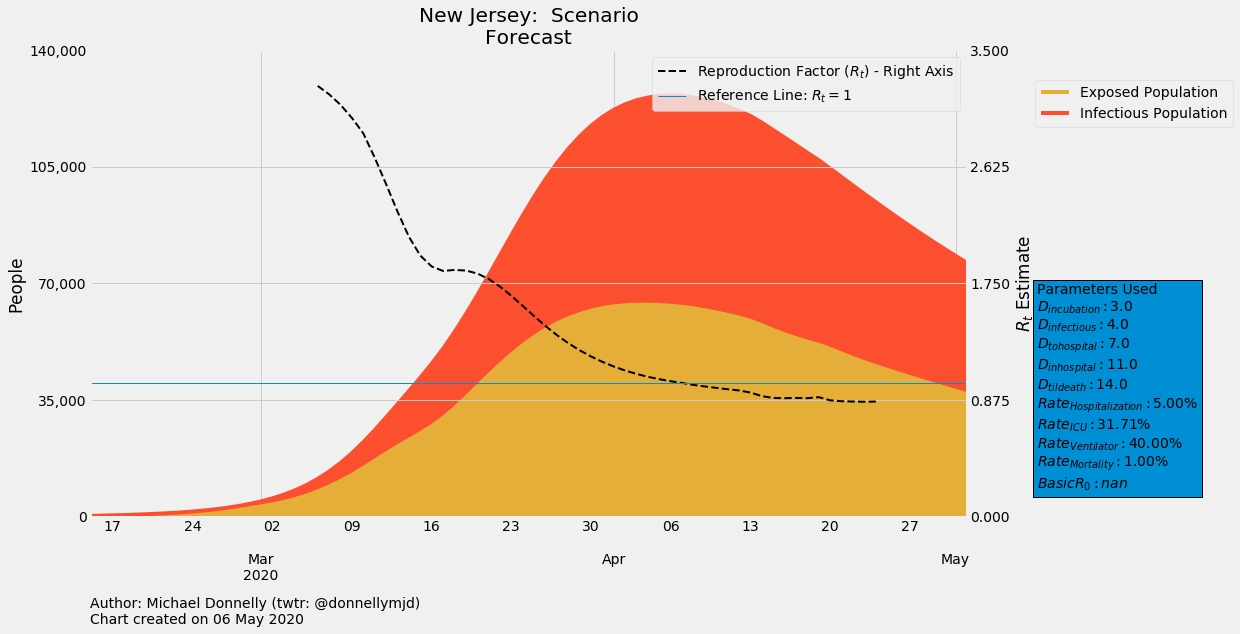

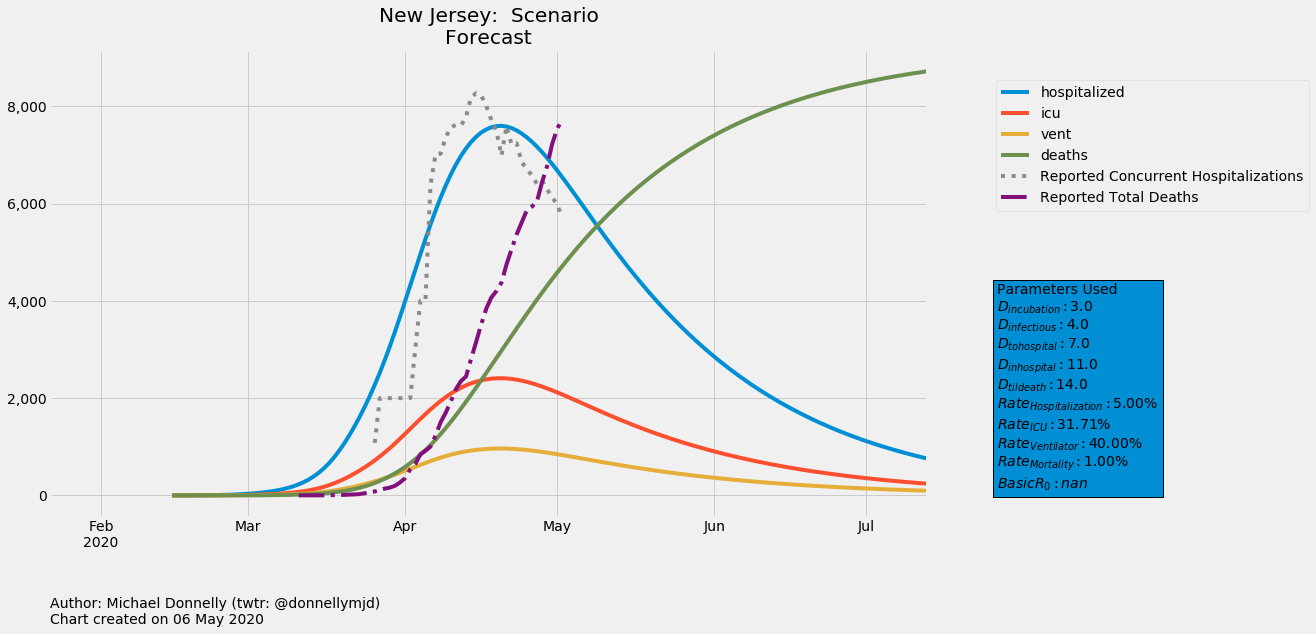

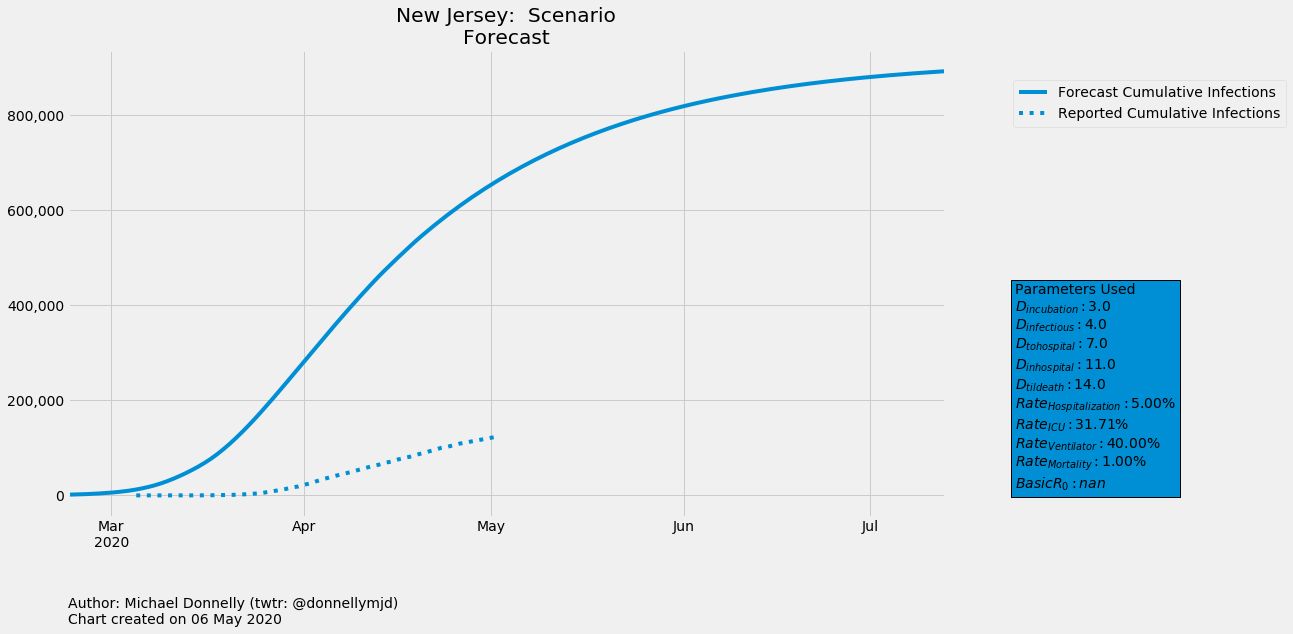

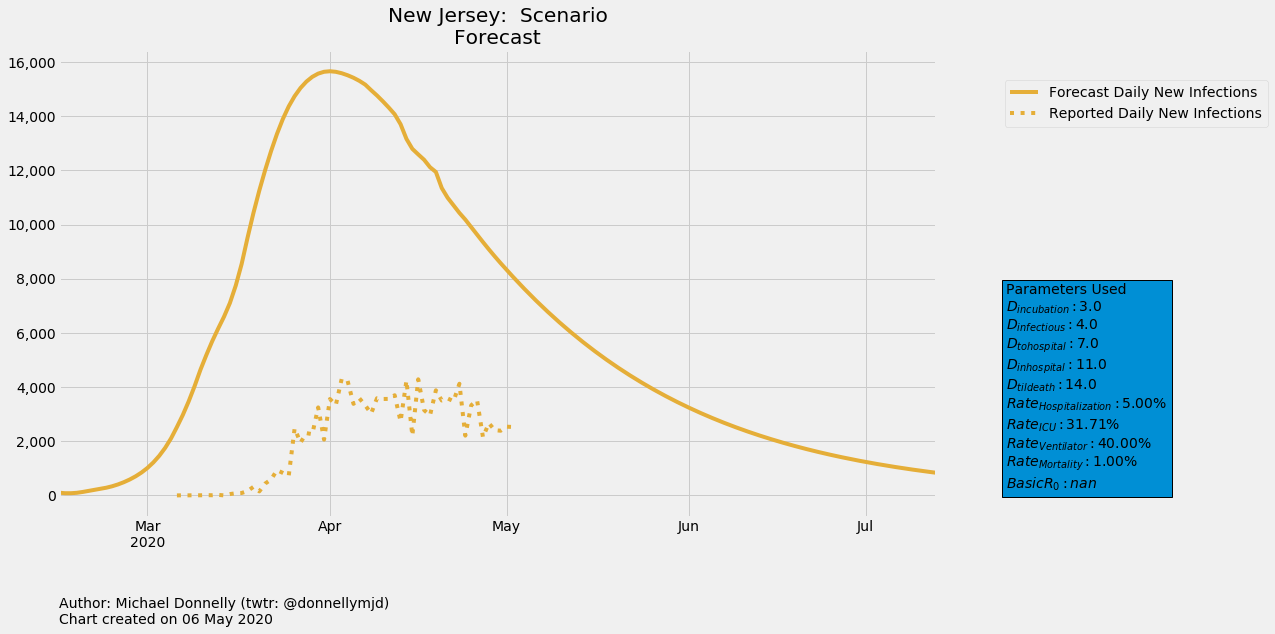

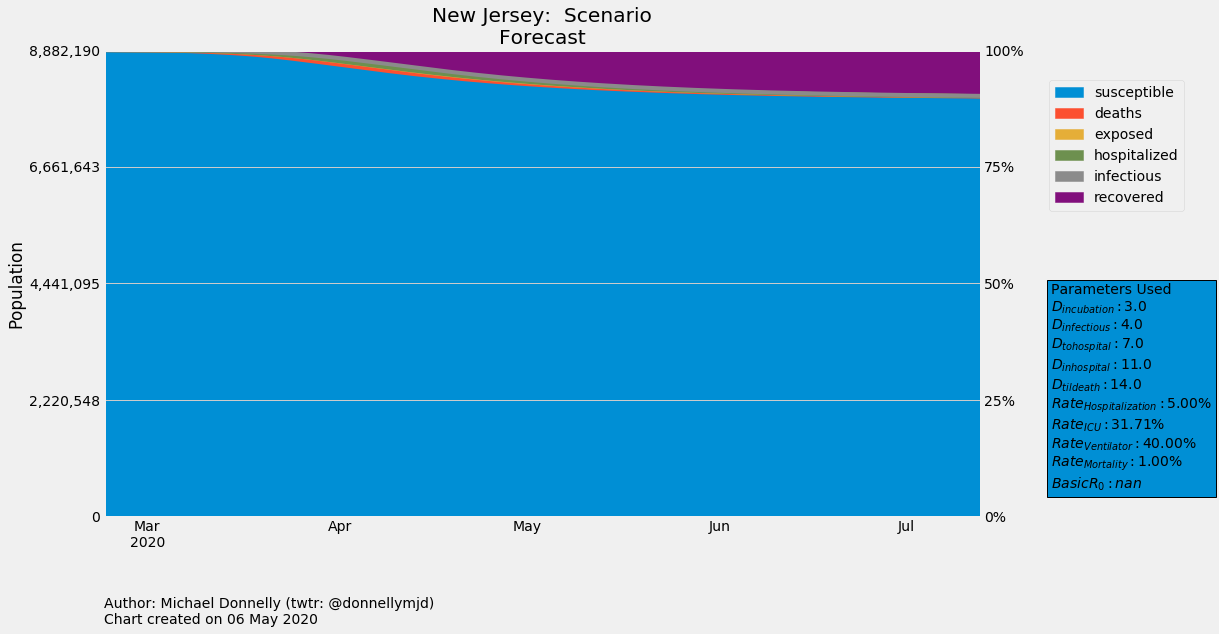

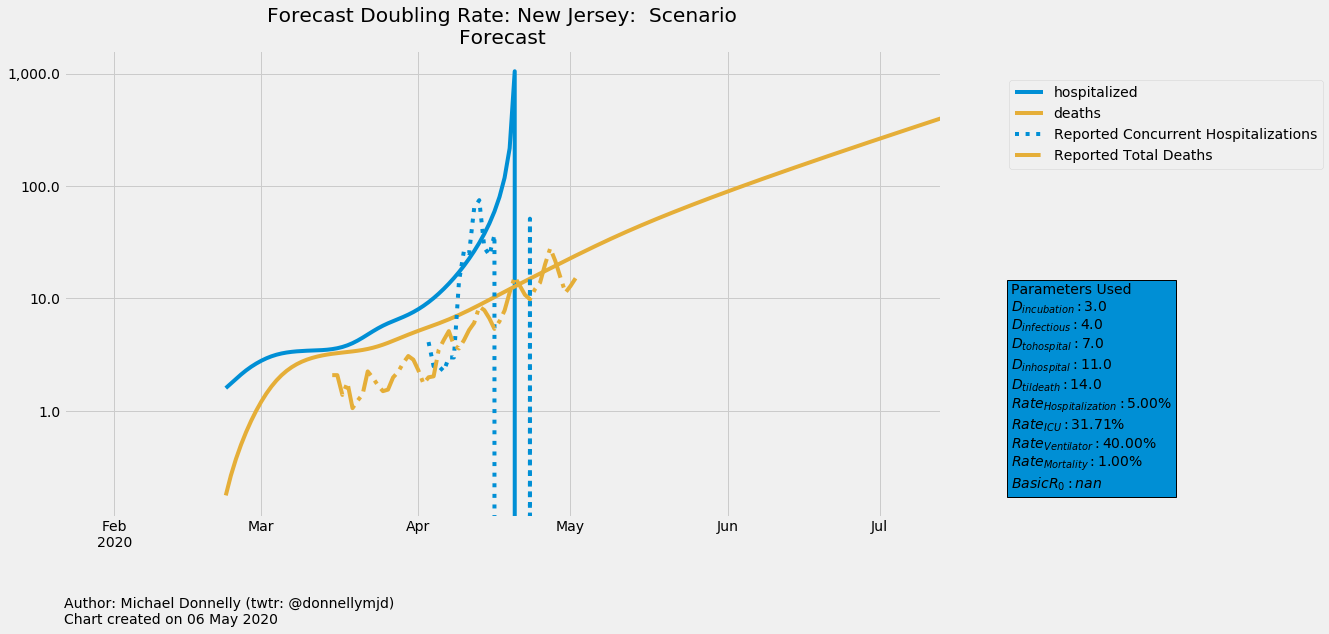

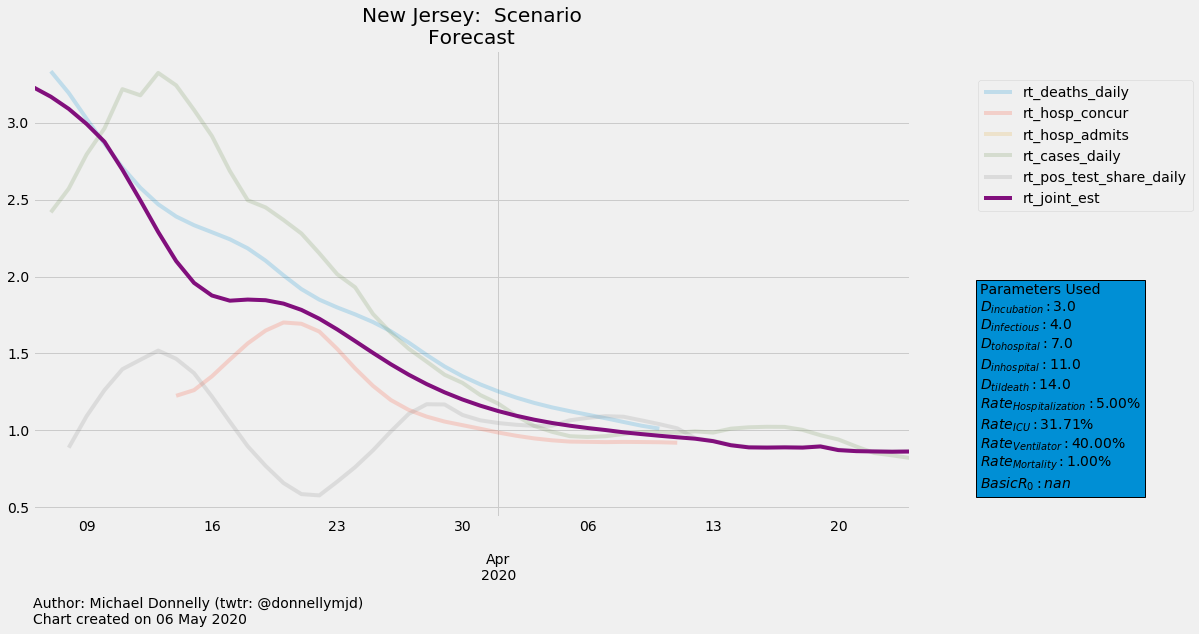

Peak Hospitalization Date:  20 Apr, 2020
Peak Hospitalization #: 7599
Peak ICU #: 2410
Peak Ventilator #: 964


In [431]:
run_all_charts(model_dict, df_agg, df_all_cohorts)


Index(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object', name='code')

In [441]:
df_rts_allstates = pd.DataFrame()
for state in df_st_testing_fmt['date'].columns:
#     print(state)
    try:
        model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, covid_params, 150)
        df_rts_allstates[state] = model_dict['df_rts'].stack()
    except:
        pass
df_rts_allstates.head()


AK        AL        AR        AZ  \
dt                                                                           
2020-03-12 rt_cases_daily           3.227659  6.747352  2.595103  2.396879   
           rt_pos_test_share_daily  1.721441       NaN  0.979115  1.748551   
2020-03-13 rt_cases_daily           2.944487  3.841588  2.465092  2.700488   
           rt_pos_test_share_daily  1.251211  1.996473  0.955047  1.885325   
2020-03-14 rt_cases_daily           2.931426  3.016637  2.491590  3.010397   

                                          CA        CO        CT        DC  \
dt                                                                           
2020-03-12 rt_cases_daily           2.141849  1.736638  3.221259  1.999829   
           rt_pos_test_share_daily  1.028029  1.126814  2.927087  0.750503   
2020-03-13 rt_cases_daily           2.219965  1.603353  3.170659  2.156906   
           rt_pos_test_share_daily  0.935899  0.910577  2.768906  0.837150   
2020-03-14 rt_cases_daily           2.275002  1.599686  2.942261  2.255656   

                                          DE        FL  ...        SD  \
dt                                                      ...             
2020-03-12 rt_cases_daily           2.503402  2.849018  ...  0.638609   
           rt_pos_test_share_daily  1.745920  1.510294  ...  0.000000   
2020-03-13 rt_cases_daily           2.281072  2.662916  ...  0.631611   
           rt_pos_test_share_daily  1.731768  1.018468  ...  0.030087   
2020-03-14 rt_cases_daily           2.264308  2.418581  ...  1.067909   

                                          TN        TX        UT        VA  \
dt                                                                           
2020-03-12 rt_cases_daily           2.419672  2.022150  3.521462  1.749138   
           rt_pos_test_share_daily  0.910306  0.565392  1.096568  0.328966   
2020-03-13 rt_cases_daily           2.539212  2.212490  3.482925  1.760221   
           rt_pos_test_share_daily  1.112700  0.326152  1.022360  0.214719   
2020-03-14 rt_cases_daily           2.664044  2.272742  2.478618  1.796530   

                                          VT        WA        WI  WV        WY  
dt                                                                              
2020-03-12 rt_cases_daily           2.940116  1.431770  2.861012 NaN  3.325063  
           rt_pos_test_share_daily  1.860375  0.841602  0.202807 NaN       NaN  
2020-03-13 rt_cases_daily           2.695718  1.425290  2.772183 NaN  2.900795  
           rt_pos_test_share_daily  2.004400  1.004701  0.238175 NaN       NaN  
2020-03-14 rt_cases_daily           2.785519  1.412633  2.618250 NaN  2.530891  

[5 rows x 51 columns]

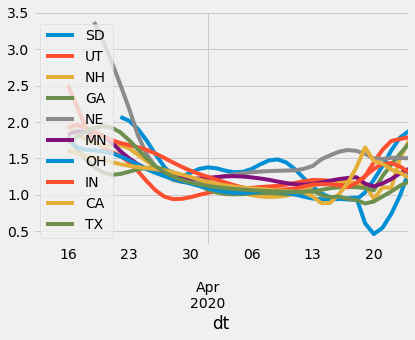

In [468]:
df_all_best_rts = df_rts_allstates.unstack(1).reorder_levels([1,0], axis=1)['rt_joint_est']
top5rts = df_all_best_rts.iloc[-1].sort_values(ascending=False).index[5:15]
df_all_best_rts[top5rts].plot()

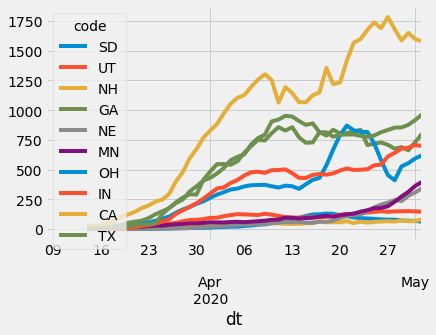

In [469]:
df_st_testing.loc[top5rts,'positive'].unstack('code')[top5rts].diff().dropna().rolling(7).mean().plot()